In [15]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import skimage.io as skio
import sfdi_fitter.preprocess as preprocess
#import sfdi_fitter.fitter as fitter
import importlib
importlib.reload(preprocess)
#importlib.reload(fitter)


import skimage.filters as skfilt
import skimage.morphology as skmorph
import skimage.measure as skmeas
import tqdm

import sys
sys.path.append('/2tb_drive/old_data/notebooks/Boris')
import lab_tools.utils.plot_utils as pu

Populating the interactive namespace from numpy and matplotlib


In [16]:
import skimage.io as skio
import numpy as np
import os
import scipy.ndimage as scnd
import glob
import matplotlib.pyplot as plt

def read_and_preprocess(sample_folder, binning_kernel_size=9, start_phase=0,n_phases=6, verbose=True):
    
    # we need to obtain available frequencies for images in folder
    #frequencies = get_available_frequencies(sample_folder)
    frequencies=np.array(['01','02','04','06','10','12','14','22','26','40','44'])

    # now we read and concatenate SFDI stack
    # reading only 3 phases for classic SFDI
    freqs, raw_intensities, mac_stack, mdc_stack = read_sfdi_stack(sample_folder, frequencies,
                                                                   n_phases=n_phases, start_phase=start_phase)

    # currently forget about Mdc (may be we should return to it later...)
    binned_mac = get_binned_stack(mac_stack, kernel_size=binning_kernel_size, pooling=True)

    binned_mdc = get_binned_stack(mdc_stack, kernel_size=binning_kernel_size, pooling=True)

    mean_mdc=np.expand_dims(binned_mdc.mean(axis=0),axis=0)

    return np.append([0],freqs),np.append(mean_mdc,binned_mac,axis=0)
def swap_axes(stack):
    return np.swapaxes(np.swapaxes(stack,0,1),1,2)

In [17]:
from sfdi_fitter.preprocess import read_image,read_single_frequency,calculate_Mac,calculate_Mdc
from sfdi_fitter.preprocess import read_sfdi_stack,get_binned_stack,get_available_frequencies

In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def get_sample_name(sample_folder):
    return sample_folder.split('/')[-2]

def get_wavelength(sample_folder):
    return os.path.basename(sample_folder)

def calculate_real_frequencies_from_prepends(freq_prepends):
    """
    calculate real spatial frequencies k = 2pi/L from frequencies prepends
    """
    return 2*np.pi*np.array([x/160. for x in [float(x) for x in freq_prepends]])

import skimage.measure as skmeas

In [20]:
sample_folders = glob.glob('/2tb_drive/old_data/data/Hemoglobin/2022-06-08/*_*')

In [21]:
folders = []
for wavelength in [560,630]:
    folders.extend([os.path.join(folder,str(wavelength)) for folder in sample_folders])

In [22]:
sample_folders_new = glob.glob('/2tb_drive/old_data/data/Hemoglobin/2022_05_10_references/*_*')

In [23]:
sample_folder=folders[1]
binning_kernel_size=9

In [24]:
sample_folders_new
for wavelength in [560,630]:
    folders.extend([os.path.join(folder,str(wavelength)) for folder in sample_folders_new])

### Собираем всё в единый пайплайн:


In [25]:
import sfdi_fitter.calibration as calibration
reference_phantoms = {}

reference_phantom_name = '070_090'
for wavelength in ['560','630']:
    reference_sample_folder = \
    f'/2tb_drive/old_data/data/Hemoglobin/2022-06-08/{reference_phantom_name}/{wavelength}'
    ref_freqs, ref_binned_mac = read_and_preprocess(sample_folder=reference_sample_folder,
                                              binning_kernel_size=9,
                                              verbose=False)
    
    reference_phantoms[wavelength] = ref_freqs,ref_binned_mac

In [26]:
stock_nigrosin_concentration_mg_ml = 0.8 #mg_ml

def get_mua_mus(sample_name,wavelength,water_volume=1000.,wv_delta=10):
    """
    calculate mua and mus in mm^{-1} using sample_name and central_wavelength
    """

    volume_nig,volume_lip = map(float,sample_name.split('_')[:2])
    total_volume = volume_nig + volume_lip + water_volume
    
    conc_nig = stock_nigrosin_concentration_mg_ml*volume_nig/total_volume
    conc_lip = volume_lip/total_volume
    #print(conc_nig*1000,conc_lip*1000)
    mua = calibration.get_mua(conc_nig,central_wavelength=int(wavelength),delta=wv_delta)
    mus = calibration.get_mus(conc_lip,central_wavelength=int(wavelength),delta=wv_delta)/1.7
    return mua,mus

In [27]:
get_mua_mus('002_100_3','630')

(0.008731505474073146, 1.69160989493632)

In [28]:
get_mua_mus('040_100_3','560')

(0.18381964766570708, 2.143587146436977)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle
from skimage.util import img_as_ubyte


In [30]:
def get_mask_for_phantom(binned_mac,verbose=True):
    mask = np.zeros_like(binned_mac[0],dtype=np.bool_)
    mask[100:300,100:300]= True
    
    image = binned_mac[0]
    edges = canny(image,mask=mask,use_quantiles=True)
    hough_radii = np.arange(40, 100, 5)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 3 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1)
    
    circle_mask = np.zeros_like(mask)
    
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle(center_y, center_x, radius,
                                        shape=image.shape)
        circle_mask[circy,circx] = True
        
    if verbose:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(edges)
        plt.title('Find edges')
        
        plt.subplot(1,3,2)
        plt.imshow(circle_mask)
        plt.title("Found circle")
        
        plt.subplot(1,3,3)
        plt.imshow(mask&circle_mask)
        plt.title('Final mask')
        
    return mask&circle_mask

In [31]:
import skimage.morphology as skmorph

In [32]:

df=pd.read_pickle('/2tb_drive/old_data/notebooks/Kirill/modeling_results_SFDI_12_ext.pkl')

df.sort_values(by=['mua','mus'],inplace=True)
df['mua']=df['mua'].astype(float)
df['mus']=df['mus'].astype(float)/10
df_mcml=df.copy()

In [33]:
def calculate_diffuse_reflectance(spatial_frequencies,df=df_mcml, mua=1., mus_prime=10., refractive_index=1.37):

    mus=mus_prime
    arg=df.apply(lambda x:((x['mua']-mua)**2)/mua+((x['mus']-mus)**2)/mus,axis=1).argmin()
    #print(df.iloc[arg].R_k)
    return df.iloc[arg].R_k

def get_reflectance_stack(freqs_test, mac_test, freqs_reference, mac_reference, ref_mua=1.,
                          ref_mus_prime=10., refractive_index=1.37):


    mac_reference_for_freqs = {f: mac for f, mac in zip(freqs_reference, mac_reference)}
    reference_diffuse_reflectance = calculate_diffuse_reflectance(freqs_test, mua=ref_mua,
                                                                  mus_prime=ref_mus_prime,
                                                                  refractive_index=refractive_index)

    mac_reference_reshape = np.stack([mac_reference_for_freqs[f] for f in freqs_test])
    return mac_test * reference_diffuse_reflectance.reshape(-1, 1, 1) / mac_reference_reshape


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

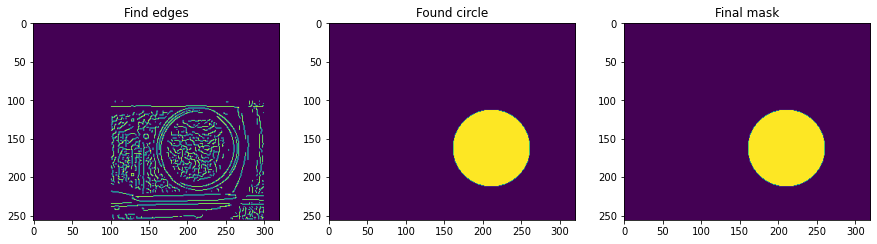

In [34]:
get_mask_for_phantom(reference_phantoms['560'][1])

In [35]:
rs = {}

In [36]:
#diffuse_model = fitter.DiffuseModel()
results = {}
fit_result={}
verbose = False
for sample_folder in tqdm.tqdm(folders[:]):
    sample_name = get_sample_name(sample_folder)
    wavelength = get_wavelength(sample_folder)
    
    name = f'{sample_name}_wv={wavelength}'
#     if name in rs:
#         continue
    #calculating reference absorption and scattering for reference phantom
    ref_freqs,ref_binned_mac = reference_phantoms[wavelength]
    
    print(f'Fitting {name}')
    #read and preprocessing the input sample
    test_freqs, mac = read_and_preprocess(sample_folder=sample_folder,
                                              binning_kernel_size=9,
                                              verbose=verbose)
    

    
    binned_mac = mac
        
    spatial_frequencies = calculate_real_frequencies_from_prepends(test_freqs)
    spatial_frequencies_ref = calculate_real_frequencies_from_prepends(ref_freqs)
    
    mua_ref,mus_ref = get_mua_mus(reference_phantom_name,wavelength)
    
    reflectance_stack = get_reflectance_stack(freqs_test=spatial_frequencies,
                          mac_test=binned_mac,
                          freqs_reference=spatial_frequencies_ref,
                          mac_reference=ref_binned_mac,
                                             ref_mua=mua_ref,
                                             ref_mus_prime=mus_ref)
    
    
    
    #print('Spatial frequencies in mm^{-1} are',spatial_frequencies)
    
    _vmin = 0.01 #np.percentile(reflectance_stack[:,phantom_mask].ravel(),1)
    _vmax = 0.8 #np.percentile(reflectance_stack[:,phantom_mask].ravel(),99)
    
    
    ref_mask  = get_mask_for_phantom(ref_binned_mac,verbose=False)
    test_mask = get_mask_for_phantom(binned_mac,verbose=False)
    fit_mask = skmorph.erosion(ref_mask&test_mask,selem=np.ones((11,11)))
    
    
    reflectance_stack[:,~fit_mask] = np.nan
    
    if verbose:
        fit_result['mua'] =regressor_mua.predict(fit).reshape(h,w)
        fit_result['mus'] =regressor_mus.predict(fit).reshape(h,w)
        xx,yy = np.indices(reflectance_stack.shape[1:])
        ids = np.arange(xx[fit_mask].shape[0])
        random_ids = np.random.choice(ids,size=20,replace=False)
        _xs,_ys = xx[fit_mask][random_ids],yy[fit_mask][random_ids]


        mua = fit_result['mua']
        mus = fit_result['mus']

        for _x,_y in zip(_xs,_ys):
            y_true = reflectance_stack[:,_x,_y]

            a,s = mua[_x,_y],mus[_x,_y]
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.title(name)
           #y_pred = diffuse_model.evaluate(spatial_freqs,mua=a,mus_prime=s)
            plt.plot(spatial_freqs,y_true,'ro')
            plt.plot(spatial_freqs,y_pred)

            plt.xlabel(r"Spatial frequency,$\rm mm^{-1}$")
            plt.ylabel("Diffuse reflectance R(k)")

            plt.subplot(1,3,2)
            plt.plot(spatial_freqs,(y_true-y_pred)**2/y_pred)

            diff=(y_true-y_pred)**2/y_pred
            plt.title(np.sum(diff))
            plt.xlabel(r"Spatial frequency,$\rm mm^{-1}$")
            plt.ylabel("Residuals")
            plt.axhline(0.,linestyle='dashed')

            plt.subplot(1,3,3)
            plt.hist(y_true-y_pred)
            plt.axvline(0.)

            plt.tight_layout()


            plt.show()
    
#     if verbose:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,3,1)
#         plt.imshow(ref_mask)
#         plt.title("Reference mask")

#         plt.subplot(1,3,2)
#         plt.imshow(test_mask)
#         plt.title("Test mask")

#         plt.subplot(1,3,3)
#         plt.imshow(fit_mask)
#         plt.title('Fit mask = RefMask x TestMask')


#         plt.figure(figsize=(8,5))
#         plt.plot(spatial_frequencies,np.mean(reflectance_stack[:,fit_mask],axis=1))
#         plt.xlabel("Spatial frequency, mm^{-1}")
#         plt.ylabel("Mean reflectance")
#         for i,r in enumerate(reflectance_stack):
#             if i%5 == 0:
#                 plt.figure(figsize=(20,4))

#             plt.subplot(1,5,i%5 + 1)
#             plt.imshow(r,vmin=_vmin,vmax=_vmax)
#             plt.title(f'Spatial frequency\nk ={spatial_frequencies[i]:.2f}' + r', $\rm mm^{-1}$')

#             plt.colorbar()

#             if i%5 == 4 or i == reflectance_stack.shape[0]-1:
#                 plt.show()
#                 plt.tight_layout()
    
    
#     fit_results = fitter.fit_diffuse_reflectance_stack(spatial_frequencies,reflectance_stack,
#                                   fit_mask=fit_mask,diffuse_model=diffuse_model,backend='cpp')
    
#     results[name] = fit_results
    rs[name] = spatial_frequencies,reflectance_stack

  0%|          | 0/32 [00:00<?, ?it/s]

Fitting 040_100_wv=560


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  3%|▎         | 1/32 [00:05<03:04,  5.96s/it]

Fitting 100_140_wv=560


  6%|▋         | 2/32 [00:12<03:01,  6.06s/it]

Fitting 060_080_wv=560


  9%|▉         | 3/32 [00:17<02:53,  5.99s/it]

Fitting 050_130_wv=560


 12%|█▎        | 4/32 [00:24<02:48,  6.00s/it]

Fitting 080_140_wv=560


 16%|█▌        | 5/32 [00:29<02:40,  5.94s/it]

Fitting 070_090_wv=560


 19%|█▉        | 6/32 [00:34<02:21,  5.44s/it]

Fitting 090_110_wv=560


 22%|██▏       | 7/32 [00:40<02:19,  5.59s/it]

Fitting 030_090_wv=560


 25%|██▌       | 8/32 [00:46<02:17,  5.73s/it]

Fitting 040_100_wv=630


 28%|██▊       | 9/32 [00:52<02:13,  5.79s/it]

Fitting 100_140_wv=630


 31%|███▏      | 10/32 [00:58<02:09,  5.89s/it]

Fitting 060_080_wv=630


 34%|███▍      | 11/32 [01:04<02:05,  5.96s/it]

Fitting 050_130_wv=630


 38%|███▊      | 12/32 [01:10<01:59,  5.98s/it]

Fitting 080_140_wv=630


 41%|████      | 13/32 [01:16<01:55,  6.08s/it]

Fitting 070_090_wv=630


 44%|████▍     | 14/32 [01:21<01:40,  5.61s/it]

Fitting 090_110_wv=630


 47%|████▋     | 15/32 [01:27<01:38,  5.77s/it]

Fitting 030_090_wv=630


 50%|█████     | 16/32 [01:33<01:32,  5.77s/it]

Fitting 030_090_3_wv=560


 53%|█████▎    | 17/32 [01:39<01:27,  5.82s/it]

Fitting 040_100_wv=560


 56%|█████▋    | 18/32 [01:45<01:22,  5.93s/it]

Fitting 030_090_2_wv=560


 59%|█████▉    | 19/32 [01:51<01:16,  5.92s/it]

Fitting 030_090_1_wv=560


 62%|██████▎   | 20/32 [01:57<01:11,  5.94s/it]

Fitting 040_100_2_wv=560


 66%|██████▌   | 21/32 [02:03<01:05,  5.94s/it]

Fitting 040_100_1_wv=560


 69%|██████▉   | 22/32 [02:09<00:59,  5.94s/it]

Fitting 040_100_3_wv=560


 72%|███████▏  | 23/32 [02:15<00:54,  6.00s/it]

Fitting 030_090_wv=560


 75%|███████▌  | 24/32 [02:21<00:47,  5.96s/it]

Fitting 030_090_3_wv=630


 78%|███████▊  | 25/32 [02:27<00:42,  6.04s/it]

Fitting 040_100_wv=630


 81%|████████▏ | 26/32 [02:33<00:36,  6.11s/it]

Fitting 030_090_2_wv=630


 84%|████████▍ | 27/32 [02:39<00:30,  6.11s/it]

Fitting 030_090_1_wv=630


 88%|████████▊ | 28/32 [02:45<00:24,  6.11s/it]

Fitting 040_100_2_wv=630


 91%|█████████ | 29/32 [02:51<00:18,  6.06s/it]

Fitting 040_100_1_wv=630


 94%|█████████▍| 30/32 [02:57<00:12,  6.08s/it]

Fitting 040_100_3_wv=630


 97%|█████████▋| 31/32 [03:04<00:06,  6.12s/it]

Fitting 030_090_wv=630


100%|██████████| 32/32 [03:10<00:00,  5.95s/it]


In [45]:
import pickle as pkl

In [46]:
 with open(f"/2tb_drive/old_data/notebooks/Kirill/{reference_phantom_name}.pkl",'wb') as f:
            pkl.dump(rs,f)

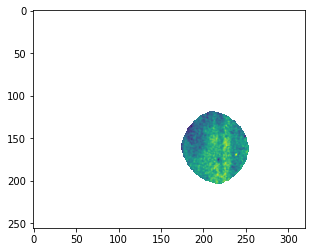

In [47]:
plt.imshow(rs['040_100_wv=560'][1][4])

- Замена коэффициента mus на mus/2 дало лучший вид зависимости коэффициентов рассеяния, чем это было ранее. Возможно, действительно можно подобрать коэффициент такой, чтобы рассеяние максимально хорошо аппроксимировалось и его использовать как референс. 

# catboost part

In [48]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


# mus_max=df.mus.max()
# mua_max=df.mua.max()

#df.mus/=10
def standard(df):
    rk_mean=np.mean(df.R_k.values)
    rk_std=np.std(df.R_k.values)
    return rk_mean,rk_std

In [49]:
df_train, df_test = train_test_split(df_mcml, test_size=0.2)
#mean,std=standard(df_mcml)

In [50]:
import pickle as pkl

In [104]:
with open('/2tb_drive/old_data/notebooks/Kirill/knn_mua_12.pkl','rb') as f:
    knn_mua_12=pkl.load(f)

with open('/2tb_drive/old_data/notebooks/Kirill/knn_mus_12.pkl','rb') as f:
    knn_mus_12=pkl.load(f)
    
with open('/2tb_drive/old_data/notebooks/Kirill/knn_scaler_12.pkl','rb') as f:
    knn_scaler_12=pkl.load(f)

In [105]:
df=df_mcml.copy()

In [106]:

X_train=df_train.R_k.apply(lambda x: x[::]).values
y_train=df_train[['mus']].values

X_train=np.array(list(X_train),dtype=float16)

X_train=knn_scaler_12.transform(X_train)

X_test=df_test.R_k.apply(lambda x: x[::]).values
y_test=df_test[['mus']].values

X_test=np.array(list(X_test),dtype=float16)

X_test=knn_scaler_12.transform(X_test)

regressor_mus=knn_mus_12#CatBoostRegressor()#CatBoostRegressor(depth=6,l2_leaf_reg=1,learning_rate=0.03)
#regressor_mus.fit(X_train,y_train)

0.007958419230128265


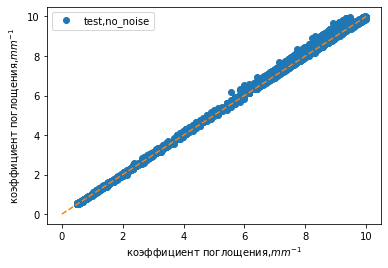

In [107]:
list1=regressor_mus.predict(X_test).reshape(-1,1)
list1=np.array(list1,dtype=float)
list2=y_test
list2=np.array(list2,dtype=float)
print((abs((np.array(list1)-np.array(list2)))/np.array(list1)).mean())

plt.plot(list2,list1,'o',label='test,no_noise')
x=np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('коэффициент поглощения,$mm^{-1}$')
plt.ylabel('коэффициент поглощения,$mm^{-1}$')
plt.legend()
plt.show()

In [116]:
X_train=df_train.R_k.apply(lambda x: x[::]).values
y_train=df_train[['mua']].values
X_train=np.array(list(X_train),dtype=float16)

X_train=knn_scaler_12.transform(X_train)

X_test=df_test.R_k.apply(lambda x: x[::]).values
y_test=df_test[['mua']].values

X_test=np.array(list(X_test),dtype=float16)

X_test=knn_scaler_12.transform(X_test)

regressor_mua=knn_mua_12
#regressor_mua=CatBoostRegressor()
#CatBoostRegressor()#CatBoostRegressor(depth=6,l2_leaf_reg=1,learning_rate=0.03)
#regressor_mua.fit(X_train,y_train)

0.008155939622691856


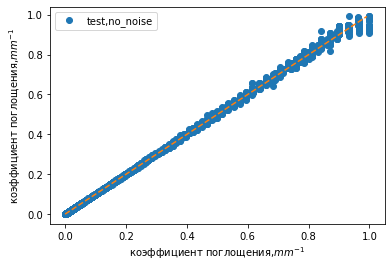

In [117]:
list1=regressor_mua.predict(X_test).reshape(-1,1)
list1=np.array(list1,dtype=float)
list2=y_test
list2=np.array(list2,dtype=float)
print((abs((np.array(list1)-np.array(list2)))/np.array(list1)).mean())

plt.plot(list2,list1,'o',label='test,no_noise')
x=np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('коэффициент поглощения,$mm^{-1}$')
plt.ylabel('коэффициент поглощения,$mm^{-1}$')
plt.legend()

In [113]:
np.logspace(0.1,2,10, dtype=int)

array([  1,   2,   3,   5,   8,  14,  23,  37,  61, 100])

In [114]:
regressor_mua=CatBoostRegressor()
grid = {'depth'         : np.logspace(0.1,2,10, dtype=int),
                 'learning_rate' : [0.03,0.04,0.01,0.07],
                  'iterations'    : [80,90, 100,150,],
         'l2_leaf_reg': [1, 3, 5, 7, 9]
                 }
grid_search_result = regressor_mua.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=False)

0:	learn: 0.2790996	test: 0.2850962	best: 0.2850962 (0)	total: 3.18ms	remaining: 251ms
1:	learn: 0.2730846	test: 0.2790066	best: 0.2790066 (1)	total: 6.88ms	remaining: 268ms
2:	learn: 0.2672752	test: 0.2731561	best: 0.2731561 (2)	total: 9.2ms	remaining: 236ms
3:	learn: 0.2616828	test: 0.2675280	best: 0.2675280 (3)	total: 11.7ms	remaining: 221ms
4:	learn: 0.2562815	test: 0.2620809	best: 0.2620809 (4)	total: 14.4ms	remaining: 216ms
5:	learn: 0.2511134	test: 0.2568572	best: 0.2568572 (5)	total: 16.5ms	remaining: 203ms
6:	learn: 0.2461284	test: 0.2518185	best: 0.2518185 (6)	total: 19.1ms	remaining: 200ms
7:	learn: 0.2413309	test: 0.2469792	best: 0.2469792 (7)	total: 21.1ms	remaining: 190ms
8:	learn: 0.2367187	test: 0.2423291	best: 0.2423291 (8)	total: 23ms	remaining: 181ms
9:	learn: 0.2322877	test: 0.2378924	best: 0.2378924 (9)	total: 25.1ms	remaining: 176ms
10:	learn: 0.2280059	test: 0.2335700	best: 0.2335700 (10)	total: 26.7ms	remaining: 168ms
11:	learn: 0.2238833	test: 0.2294172	best: 0

KeyboardInterrupt: 

In [44]:
#grid_search_result['params']{'depth': 14, 'l2_leaf_reg': 1, 'iterations': 150, 'learning_rate': 0.07}

{'depth': 14, 'l2_leaf_reg': 1, 'iterations': 150, 'learning_rate': 0.07}

In [61]:
dic= {'depth': 14, 'l2_leaf_reg': 15, 'iterations': 50, 'learning_rate': 0.01}

In [62]:
regressor_mua=CatBoostRegressor()#(**dic)

In [63]:
regressor_mua.fit(X_train,y_train,verbose=False)
#regressor_mua

0.008155939622691856


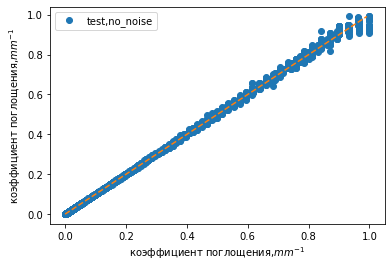

In [118]:
#list1=pipe.predict(X_test)
list1=regressor_mua.predict(X_test).reshape(-1,1)
list1=np.array(list1,dtype=float)
list2=y_test
list2=np.array(list2,dtype=float)
print((abs((np.array(list1)-np.array(list2)))/np.array(list1)).mean())

plt.plot(list2,list1,'o',label='test,no_noise')
x=np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('коэффициент поглощения,$mm^{-1}$')
plt.ylabel('коэффициент поглощения,$mm^{-1}$')
plt.legend()

In [119]:
from sklearn.preprocessing import StandardScaler

In [120]:
from sklearn.impute import SimpleImputer

In [121]:
imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=1000)

In [122]:

results={}
for i in tqdm.tqdm(rs):
    #print(i)
    fit_result={}
    reflectance_stack=rs[i][1]
    f,h,w=reflectance_stack.shape
    
    fit=np.stack(reflectance_stack,-1).reshape(h*w,f)
    
    fit=knn_scaler_12.transform(fit)
    fit=imp.fit_transform(fit)
    fit_result['mua'] =regressor_mua.predict(fit).reshape(h,w)#knn_mua_16.predict(fit).reshape(h,w)
    fit_result['mus'] =regressor_mus.predict(fit).reshape(h,w)
    #fit_result['mus'] =knn_mus_16.predict(fit).reshape(h,w)
    results[i] = fit_result

100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


In [123]:
fit

array([[1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       ...,
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.]])

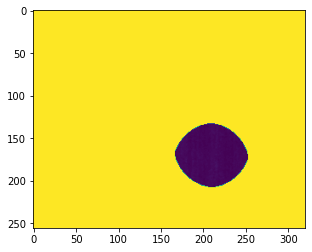

In [124]:
plt.imshow(fit_result['mus'])

In [125]:
keys=list(results.keys())
mua1=results[keys[0]]['mua']
mua2=results['080_140_wv=560']['mua']

In [126]:
from scipy.stats import mode
def get_mask_without_outliers(mua):
    #mean=mua.mean()
    mask  = mua!=mode(mua).mode[0][0]#(mua<0.98*mean) | (mua>1.02*mean)
    return skmorph.binary_erosion(mask,selem=np.ones((13,13)))

def get_percentile_limits(mua,mask=None,low=5,high=95):
    if mask is None:
        mask = np.ones(mua.shape,dtype=np.bool_)
    
    return np.percentile(mua[mask],low),np.percentile(mua[mask],high)

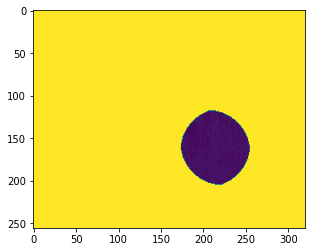

In [127]:
plt.imshow(results['040_100_wv=560']['mus'])

040_100_wv=560


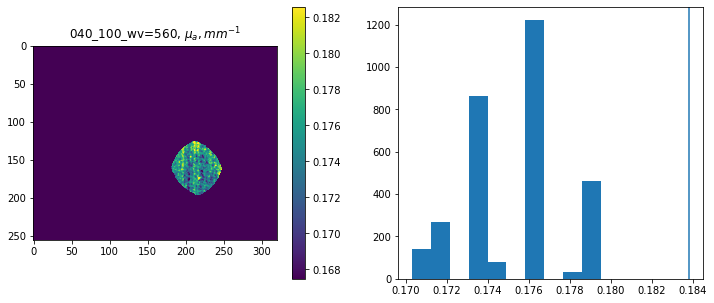

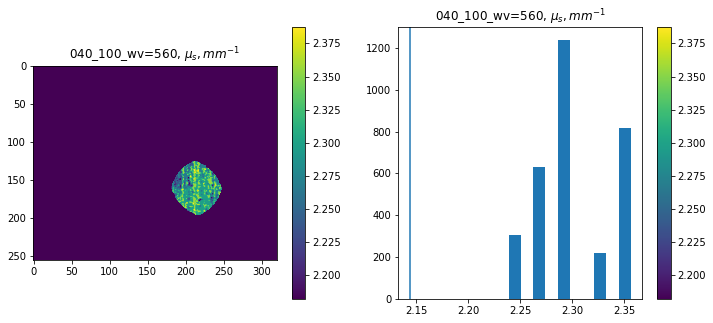

100_140_wv=560


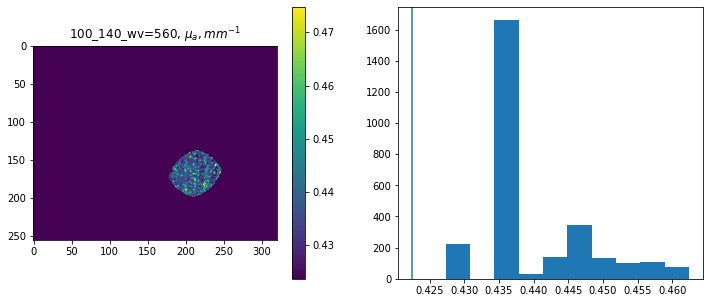

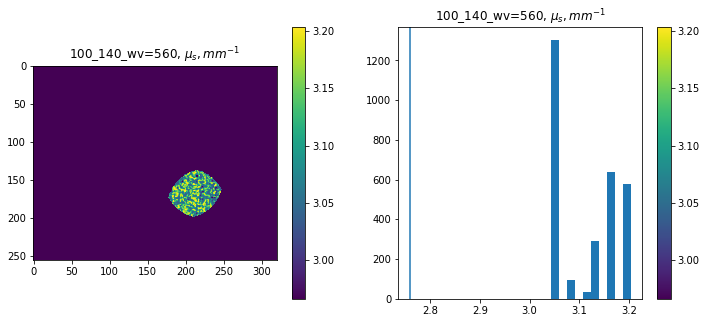

060_080_wv=560


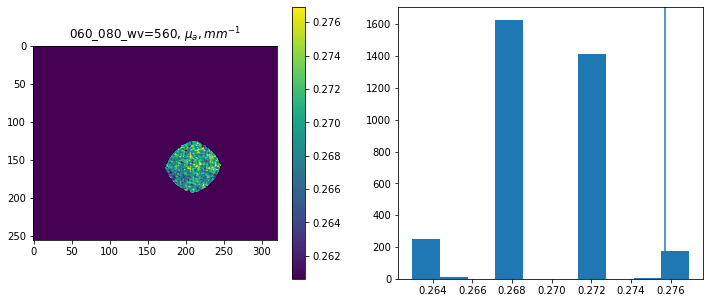

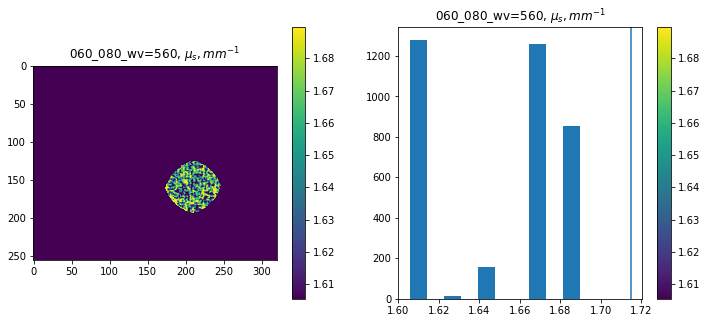

050_130_wv=560


KeyboardInterrupt: 

In [128]:

for name, result in results.items():
    print(name)
    mua = result['mua'].copy()
    mus = result['mus'].copy()
    
    mask = get_mask_without_outliers(mua)
    mua[~mask] = 0
    mus[~mask] = 0

    sample_name = '_'.join(name.split('_')[:2])
    wavelength = name.split('=')[-1]
    
    true_mua,true_mus = get_mua_mus(sample_name,wavelength)
    
    spatial_frequencies,reflectance = rs[name]
    
#     plt.figure(figsize=(8,5))
#     r = reflectance[3].copy()
#     r[~mask] = np.nan
#     plt.imshow(r,vmin=0.25,vmax=0.3)
#     plt.show()
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)

    vmin,vmax = get_percentile_limits(mua,mask,low=1,high=99)
    plt.imshow(mua,vmin=vmin,vmax=vmax)
    plt.title(f'{name}, ' + r'$\mu_a, mm^{-1}$')

    plt.colorbar()
    plt.subplot(1,2,2)
    vmin,vmax = get_percentile_limits(mua,mask)
    plt.hist(mua[mask],range=(vmin,vmax))
    plt.axvline(true_mua)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)

    vmin,vmax = get_percentile_limits(mus,mask,low=1,high=99)
    plt.imshow(mus,vmin=vmin,vmax=vmax)
    plt.title(f'{name}, ' + r'$\mu_s, mm^{-1}$')

    plt.colorbar()
    plt.subplot(1,2,2)
    vmin,vmax = get_percentile_limits(mus,mask)
    plt.hist(mus[mask],range=(vmin,vmax))
    plt.axvline(true_mus)
    
    plt.title(f'{name}, ' + r'$\mu_s, mm^{-1}$')
    
    
    
    plt.colorbar()
    plt.show()
    
#     xx,yy = np.indices(reflectance.shape[1:])
#     ids = np.arange(xx[mask].shape[0])
#     random_ids = np.random.choice(ids,size=20,replace=False)
#     _xs,_ys = xx[mask][random_ids],yy[mask][random_ids]
    
#     for _x,_y in zip(_xs,_ys):
#         y_true = reflectance[:,_x,_y]
        
#         a,s = mua[_x,_y],mus[_x,_y]
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,3,1)
#         y_pred = diffuse_model.evaluate(spatial_frequencies,mua=a,mus_prime=s)
#         plt.plot(spatial_frequencies,y_true,'ro')
    
#         plt.plot(spatial_frequencies,y_pred)
        
#         plt.xlabel(r"Spatial frequency,$\rm mm^{-1}$")
#         plt.ylabel("Diffuse reflectance R(k)")
    
#         plt.subplot(1,3,2)
#         plt.plot(spatial_frequencies,y_true-y_pred)
#         plt.xlabel(r"Spatial frequency,$\rm mm^{-1}$")
#         plt.ylabel("Residuals")
#         plt.axhline(0.,linestyle='dashed')
        
#         plt.subplot(1,3,3)
#         plt.hist(y_true-y_pred)
#         plt.axvline(0.)
        
#         plt.tight_layout()
        
        
#         plt.show()
    
    

In [129]:
fit_df = {k:[] for k in ['mua','mus','name']}

for name, result in results.items():
    print(name)
    #plt.figure(figsize=(12,10))
    mua = result['mua'].copy()
    mus = result['mus'].copy()
    
    mask = get_mask_without_outliers(mua)
    
    
    low_a,high_a = get_percentile_limits(mua,mask)
    low_s,high_s = get_percentile_limits(mus,mask)
    mask = mask&(mua>low_a)&(mua<high_a)&(mus>low_s)&(mus<high_s)
    
    for i,par in enumerate(['mua','mus']):
        values = result[par][mask]
        
        fit_df[par].extend(values.tolist())
        
        _title = par# if i != 1 else f'{name}\n{par}'
        
    fit_df['name'].extend([name]*np.sum(mask))
        
    #plt.show()
df = pd.DataFrame(fit_df)

040_100_wv=560
100_140_wv=560
060_080_wv=560
050_130_wv=560
080_140_wv=560
070_090_wv=560
090_110_wv=560
030_090_wv=560
040_100_wv=630
100_140_wv=630
060_080_wv=630
050_130_wv=630
080_140_wv=630
070_090_wv=630
090_110_wv=630
030_090_wv=630
030_090_3_wv=560
030_090_2_wv=560
030_090_1_wv=560
040_100_2_wv=560
040_100_1_wv=560
040_100_3_wv=560
030_090_3_wv=630
030_090_2_wv=630
030_090_1_wv=630
040_100_2_wv=630
040_100_1_wv=630
040_100_3_wv=630


In [130]:
df['wavelength'] = df['name'].apply(lambda x: x.split('=')[1])
df['sample_name'] = df['name'].apply(lambda name:"_".join(name.split("_")[:]))

In [131]:
def get_wv_from_name(name):
    return name.split('=')[-1]

In [132]:
for name in df['name'].unique():
    wavelength = get_wv_from_name(name)
    sample_name = '_'.join(name.split('_')[:])
    df.loc[df['name'] == name,'true_mua'] = get_mua_mus(sample_name,wavelength=int(wavelength))[0]

In [133]:
for name in df['name'].unique():
    wavelength = get_wv_from_name(name)
    sample_name = '_'.join(name.split('_')[:])
    df.loc[df['name'] == name,'true_mus'] = get_mua_mus(sample_name,wavelength=int(wavelength))[1]

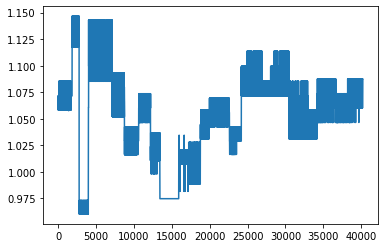

In [134]:
plt.plot(df['mus']/df['true_mus'])

In [135]:
np.std(abs(df.true_mus-df['mus']))

0.08112822101706803

In [136]:
df['true_mua']

0        0.183820
1        0.183820
2        0.183820
3        0.183820
4        0.183820
           ...   
40167    0.168809
40168    0.168809
40169    0.168809
40170    0.168809
40171    0.168809
Name: true_mua, Length: 40172, dtype: float64

In [137]:
df_mean=df.groupby(df.sample_name).mean()

Text(0.5, 0, 'True mus, mm-1')

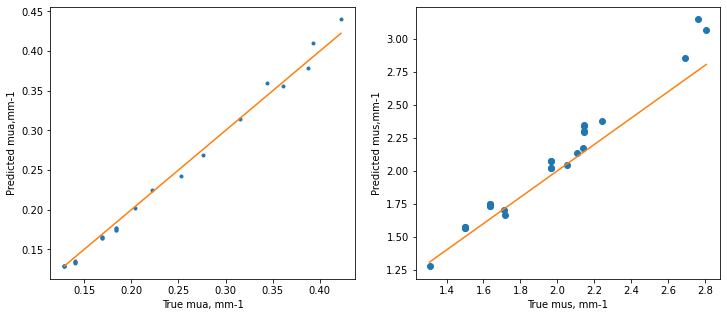

In [138]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(df_mean['true_mua'],df_mean['mua'],'.')

_refs = np.linspace(df_mean.true_mua.min(),df_mean.true_mua.max())
plt.plot(_refs,_refs)

plt.ylabel("Predicted mua,mm-1")
plt.xlabel("True mua, mm-1")

plt.subplot(1,2,2)
plt.plot(df_mean['true_mus'],df_mean['mus'],'o')

_refs = np.linspace(df_mean.true_mus.min(),df_mean.true_mus.max())
plt.plot(_refs,_refs)


plt.ylabel("Predicted mus,mm-1")
plt.xlabel("True mus, mm-1")

In [139]:
names=['030_090_wv=630', '030_090_3_wv=560',
       '030_090_2_wv=560', '030_090_1_wv=560', '040_100_2_wv=560',
       '040_100_1_wv=560', '040_100_3_wv=560', '030_090_3_wv=630',
       '030_090_2_wv=630', '030_090_1_wv=630', '040_100_2_wv=630',
       '040_100_1_wv=630', '040_100_3_wv=630']

In [140]:
df_orig=df.copy()

In [141]:
df_old=df[df.apply(lambda row: row['name'] not in names,axis=1 )]

In [142]:
df_new=df[df.apply(lambda row: row['name'] in names,axis=1 )]

Text(0.5, 0, 'True mus, mm-1')

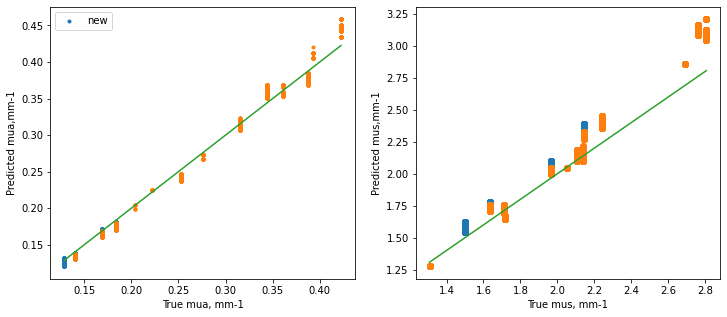

In [143]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df=df_new
plt.plot(df['true_mua'],df['mua'],'.',label='new')
plt.legend()
df=df_old
plt.plot(df['true_mua'],df['mua'],'.')

df=df_orig
_refs = np.linspace(df.true_mua.min(),df.true_mua.max())
plt.plot(_refs,_refs)

plt.ylabel("Predicted mua,mm-1")
plt.xlabel("True mua, mm-1")

plt.subplot(1,2,2)

df=df_new
plt.plot(df['true_mus'],df['mus'],'o')

df=df_old
plt.plot(df['true_mus'],df['mus'],'o')
df=df_orig
_refs = np.linspace(df.true_mus.min(),df.true_mus.max())
plt.plot(_refs,_refs)


plt.ylabel("Predicted mus,mm-1")
plt.xlabel("True mus, mm-1")

**Выводы:**
- Некоторые фантомы (см. `030_200`) фитятся хуже, чем должны были бы. Почему?
- Какова ошибка измерений?
- Вероятно, коэффициенты поглощения взяты не совсем верными для текущих фантомов. Возможно, надо переделать c корректными поглощениями
- Каковы спектры эмиссии 

In [133]:
def compose_df_results(results):
    fit_df = {k:[] for k in ['mua','mus','chi2','name']}

    for name, result in results.items():
    
        #plt.figure(figsize=(12,10))
        mua = result['mua'].copy()
        mus = result['mus'].copy()

        mask = get_mask_without_outliers(mua)


        low_a,high_a = get_percentile_limits(mua,mask)
        low_s,high_s = get_percentile_limits(mus,mask)
        mask = mask&(mua>low_a)&(mua<high_a)&(mus>low_s)&(mus<high_s)

        for i,par in enumerate(['mua','mus','chi2']):
            values = result[par][mask]

            fit_df[par].extend(values.tolist())

            _title = par if i != 1 else f'{name}\n{par}'

        fit_df['name'].extend([name]*np.sum(mask))

        #plt.show()
    df = pd.DataFrame(fit_df)
    
    for name in df['name'].unique():
        wavelength = get_wv_from_name(name)
        sample_name = '_'.join(name.split('_')[:2])
        df.loc[df['name'] == name,'true_mua'] = get_mua_mus(sample_name,wavelength=int(wavelength))[0]
        
    return df

In [223]:
import pickle as pkl

In [224]:
sample_names = [os.path.basename(path) for path in sample_folders]

In [225]:
sample_names

['040_100',
 '100_140',
 '060_080',
 '050_130',
 '080_140',
 '070_090',
 '090_110',
 '030_090']

In [226]:
fit_again = False
if fit_again:
    verbose = False

    for reference_phantom_name in sample_names:

        reference_phantoms = {}

        for wavelength in ['560','630']:
            reference_sample_folder = \
            f'/2tb_drive/old_data/data/Hemoglobin/2022-06-08/{reference_phantom_name}/{wavelength}'
            ref_freqs, ref_binned_mac = preprocess.read_and_preprocess(sample_folder=reference_sample_folder,
                                                      binning_kernel_size=9,
                                                      verbose=verbose)

            reference_phantoms[wavelength] = ref_freqs,ref_binned_mac[:,]

        diffuse_model = fitter.DiffuseModel()
        results = {}
        rs = {}

        dfs = []
        for alpha in tqdm.tqdm(np.linspace(0.3,0.6,num=10)):

            for sample_folder in folders:
                sample_name = get_sample_name(sample_folder)
                wavelength = get_wavelength(sample_folder)

                name = f'{sample_name}_wv={wavelength}'
                #calculating reference absorption and scattering for reference phantom
                ref_freqs,ref_binned_mac = reference_phantoms[wavelength]

                print(f'Fitting {name}',end='... ')
                #read and preprocessing the input sample
                test_freqs, mac_1 = preprocess.read_and_preprocess(sample_folder=sample_folder,
                                                          binning_kernel_size=9,
                                                          verbose=verbose)

                try:
                    test_freqs, mac_2 = preprocess.read_and_preprocess(sample_folder=sample_folder,
                                                              binning_kernel_size=9,start_phase=3,
                                                              verbose=verbose)
                except ValueError:
                    print(f"Something went wrong when reading {sample_folder}")
                    mac_2 = mac_1.copy()

                binned_mac = np.sqrt((mac_1**2 + mac_2**2)/2)


                spatial_frequencies = calculate_real_frequencies_from_prepends(test_freqs)
                spatial_frequencies_ref = calculate_real_frequencies_from_prepends(ref_freqs)

                mua_ref,mus_ref = get_mua_mus(reference_phantom_name,wavelength)

                mus_ref = alpha*mus_ref
                reflectance_stack = fitter.get_reflectance_stack(freqs_test=spatial_frequencies,
                                      mac_test=binned_mac,
                                      freqs_reference=spatial_frequencies_ref,
                                      mac_reference=ref_binned_mac,
                                                         ref_mua=mua_ref,
                                                         ref_mus_prime=mus_ref)


                ref_mask  = get_mask_for_phantom(ref_binned_mac,verbose=False)
                test_mask = get_mask_for_phantom(binned_mac,verbose=False)
                fit_mask = skmorph.erosion(ref_mask&test_mask,selem=np.ones((11,11)))


                reflectance_stack[:,~fit_mask] = np.nan

                fit_results = fitter.fit_diffuse_reflectance_stack(spatial_frequencies,reflectance_stack,
                                              fit_mask=fit_mask,diffuse_model=diffuse_model,backend='cpp')

                results[name] = fit_results
                rs[name] = spatial_frequencies,reflectance_stack

            df = compose_df_results(results)
            for name in df['name'].unique():
                wavelength = get_wv_from_name(name)
                sample_name = '_'.join(name.split('_')[:2])
                df.loc[df['name'] == name,'true_mus'] = alpha*get_mua_mus(sample_name,wavelength=int(wavelength))[1]


            print(f'alpha = {alpha:.2f}')

            plt.figure(figsize=(12,5))
            plt.subplot(1,2,1)
            plt.plot(df['true_mua'],df['mua'],'.')

            _refs = np.linspace(df.true_mua.min(),df.true_mua.max())
            plt.plot(_refs,_refs)

            plt.ylabel("Predicted mua,mm-1")
            plt.xlabel("True mua, mm-1")

            plt.subplot(1,2,2)
            plt.plot(df['true_mus'],df['mus'],'o')

            _refs = np.linspace(df.true_mus.min(),df.true_mus.max())
            plt.plot(_refs,_refs)


            plt.ylabel("Predicted mua,mm-1")
            plt.xlabel("True mua, mm-1")
            plt.show()

            df['alpha'] = alpha
            dfs.append(df)

        df = pd.concat(dfs,axis=0,ignore_index=True)
        df['reference'] = reference_phantom_name
        with open(f"PHANTOM_CALIBRATION_PARAMETER_ref={reference_phantom_name}.pkl",'wb') as f:
            pkl.dump(df,f)

In [227]:
import pickle as pkl

In [228]:
with open("PHANTOM_CALIBRATION_PARAMETER.pkl",'rb') as f:
    dfs = pkl.load(f)

In [229]:
df = pd.concat(dfs,axis=0,ignore_index=True)

In [230]:
df.alpha.unique()

array([0.25      , 0.27631579, 0.30263158, 0.32894737, 0.35526316,
       0.38157895, 0.40789474, 0.43421053, 0.46052632, 0.48684211,
       0.51315789, 0.53947368, 0.56578947, 0.59210526, 0.61842105,
       0.64473684, 0.67105263, 0.69736842, 0.72368421, 0.75      ])

In [231]:
def get_r2(y_true,y_pred):
    return 1 - np.mean((y_true-y_pred)**2)/np.mean((y_true - np.mean(y_true))**2)

In [73]:
for par in ['mua','mus']:
    r2s = []
    alphas  = [] 
    for alpha in df.alpha.unique():
        _df = df[df.alpha == alpha]
        y_true = _df[f'true_{par}']
        y_pred = _df[par]
        
        r2 = np.mean(get_r2(y_true,y_pred))

        r2s.append(r2)
        alphas.append(alpha)
    plt.title(par)
    plt.plot(alphas,r2s,'o-',label=par)
    print(alphas[np.argmax(r2s)])
plt.ylim(0.90,1.0)
# plt.xlim(0.2,0.5)
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'alpha'

In [233]:
best_df = df[df.alpha ==alphas[np.argmax(r2s)]]

(array([ 6712.,  1161., 10021.,  5713.,  4389., 10163.,  3194.,     0.,
         2518.,  6773.]),
 array([0.69226897, 0.78837489, 0.88448081, 0.98058672, 1.07669264,
        1.17279856, 1.26890448, 1.3650104 , 1.46111632, 1.55722224,
        1.65332815]),
 <BarContainer object of 10 artists>)

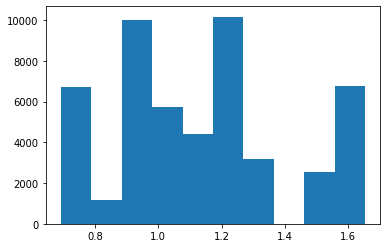

In [234]:
plt.hist(best_df['mus'])

### Cross-validation of best $\alpha$ using different alpha

In [235]:
df_paths = glob.glob('PHANTOM_CALIBRATION_PARAMETER_ref*.pkl')

In [236]:
dfs = []
for path in df_paths:
    with open(path,'rb') as f:
        dfs.append(pkl.load(f))

In [237]:
df = pd.concat(dfs,axis=0,ignore_index=True)

In [238]:
def get_r2s(df):
    r2_vals = {}
    for par in ['mua','mus']:
        r2s = []
        alphas  = [] 
        for alpha in df.alpha.unique():
            _df = df[df.alpha == alpha]
            y_true = _df[f'true_{par}']
            y_pred = _df[par]

            r2 = np.mean(get_r2(y_true,y_pred))

            r2s.append(r2)
            alphas.append(alpha)
        r2_vals[f'r2_{par}'] = r2s
    r2_vals['alpha'] = alphas
    return pd.DataFrame(r2_vals)


In [239]:
r2_df

NameError: name 'r2_df' is not defined

best alpha for r2mus: 0.4444444444444444


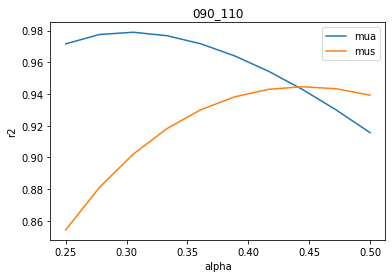

best alpha for r2mus: 0.3333333333333333


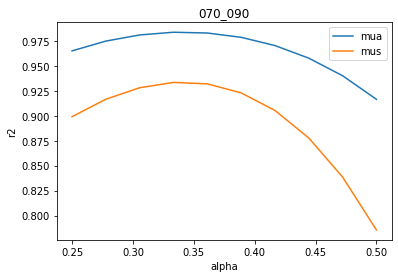

best alpha for r2mus: 0.5


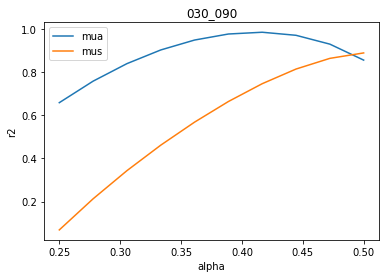

best alpha for r2mus: 0.5


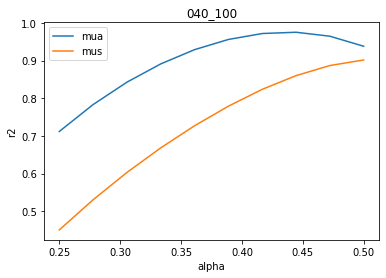

best alpha for r2mus: 0.3055555555555556


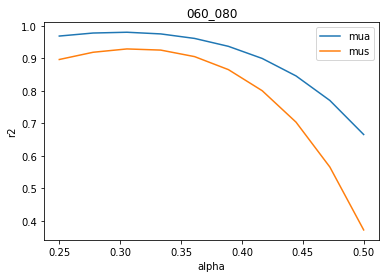

best alpha for r2mus: 0.3888888888888889


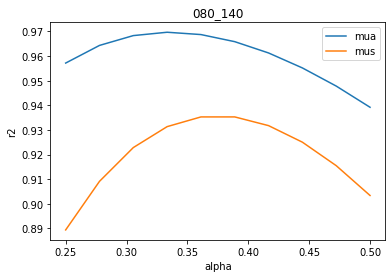

best alpha for r2mus: 0.3888888888888889


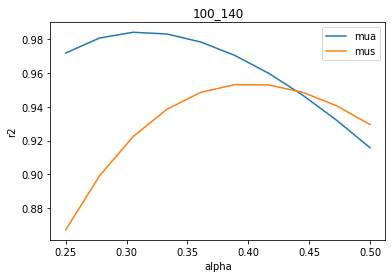

best alpha for r2mus: 0.5


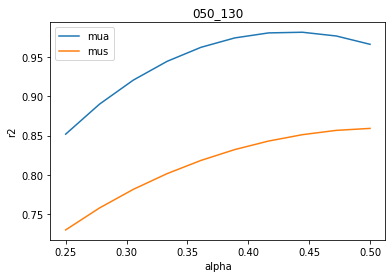

In [240]:
best_alphas  = []
for ref in df.reference.unique():
    _df = df[df.reference == ref]
    
    
    plt.figure()
    r2_df = get_r2s(_df)
        
    plt.plot(r2_df['alpha'],r2_df['r2_mua'],label='mua')
    plt.plot(r2_df['alpha'],r2_df['r2_mus'],label='mus')
    plt.xlabel("alpha")
    plt.ylabel("r2")
    plt.legend()
    
    best_alpha = r2_df['alpha'].iloc[r2_df['r2_mus'].idxmax()]
    print('best alpha for r2mus:',best_alpha)
    
    best_alphas.append(best_alpha)
    plt.title(ref)
    plt.show()

In [241]:
df.reference.unique()

array(['090_110', '070_090', '030_090', '040_100', '060_080', '080_140',
       '100_140', '050_130'], dtype=object)

In [242]:
_df.alpha.unique()

array([0.25      , 0.27777778, 0.30555556, 0.33333333, 0.36111111,
       0.38888889, 0.41666667, 0.44444444, 0.47222222, 0.5       ])

In [243]:
pu.load_figure_style()

In [244]:
df.head(3)

,mua,mus,chi2,name,true_mua,true_mus,alpha,reference
0,0.205057,1.038059,0.0,040_100_wv=560,0.18382,0.911025,0.25,090_110
1,0.202460,1.025529,0.0,040_100_wv=560,0.18382,0.911025,0.25,090_110
2,0.202045,1.025456,0.0,040_100_wv=560,0.18382,0.911025,0.25,090_110


In [245]:
df['wavelength'] = df['name'].apply(lambda x: x.split('=')[-1])

In [246]:
_xs

array([165, 177, 169, 159, 157, 158, 177, 145, 194, 174, 150, 159, 178,
       160, 168, 167, 163, 199, 151, 152])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


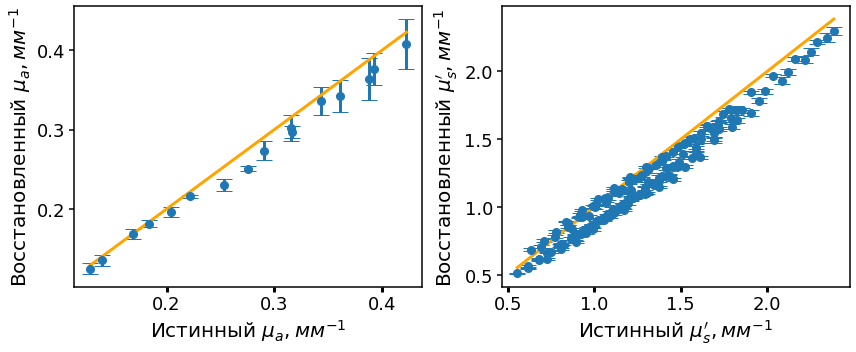

In [247]:
_xs_mua=[]
_xs_mus=[]

plt.figure(figsize=(12,5))
for mua in _df.true_mua.unique():
    plt.subplot(1,2,1)
    mua_std=_df[_df.true_mua==mua].mua.std()
    mua_mean=_df[_df.true_mua==mua].mua.mean()
    _xs_mua.append(mua)
    plt.errorbar(mua,mua_mean,yerr=mua_std,fmt='o',color='C0', capsize=8)
    

xs=np.linspace(_df.true_mua.unique().min(),_df.true_mua.unique().max(),100)
plt.plot(xs,xs,'-',color='orange')
plt.xlabel(r"Истинный $\mu_a, мм^{-1}$")
plt.ylabel(r"Восстановленный $\mu_a, мм^{-1}$")
for mus in _df.true_mus.unique():
    plt.subplot(1,2,2)
    mus_std=_df[_df.true_mus==mus].mus.std()
    mus_mean=_df[_df.true_mus==mus].mus.mean()
    _xs_mus.append(mus)
    plt.errorbar(mus,mus_mean,yerr=mus_std,fmt='o',color='C0', capsize=8)
    
xs=np.linspace(_df.true_mus.unique().min(),_df.true_mus.unique().max(),100)

plt.plot(xs,xs,'-',color='orange')
plt.xlabel(r"Истинный $\mu_s', мм^{-1}$")
plt.ylabel(r"Восстановленный $\mu_s', мм^{-1}$")
plt.tight_layout()
plt.show()

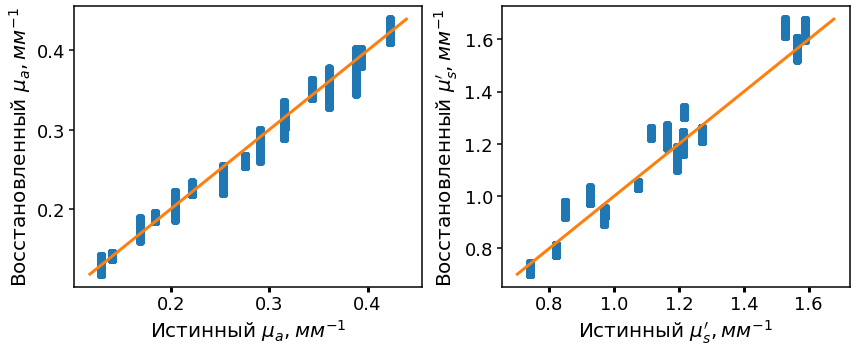

In [248]:
best_alphas  = []
for ref in ['070_090']:
    _df = df[(df.reference == ref)&(df.alpha<0.34)&(df.alpha>0.31)]
    
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
        
    x = np.linspace(_df['mua'].min(),_df['mua'].max())
    plt.plot(_df['true_mua'],_df['mua'],'o')
    plt.plot(x,x)
    plt.xlabel(r"Истинный $\mu_a, мм^{-1}$")
    plt.ylabel(r"Восстановленный $\mu_a, мм^{-1}$")
    plt.subplot(1,2,2)
    plt.plot(_df['true_mus'],_df['mus'],'o')

    s = np.linspace(_df.mus.min(),_df.mus.max())

    plt.plot(s,s)
    
    plt.xlabel(r"Истинный $\mu_s', мм^{-1}$")
    plt.ylabel(r"Восстановленный $\mu_s', мм^{-1}$")
    plt.tight_layout()
    plt.show()

In [249]:
np.std((_df['true_mua'] - _df['mua']))

0.010337722505961775

In [250]:
np.std((_df['true_mus'] - _df['mus']))

0.06295223127101923

In [72]:
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by 

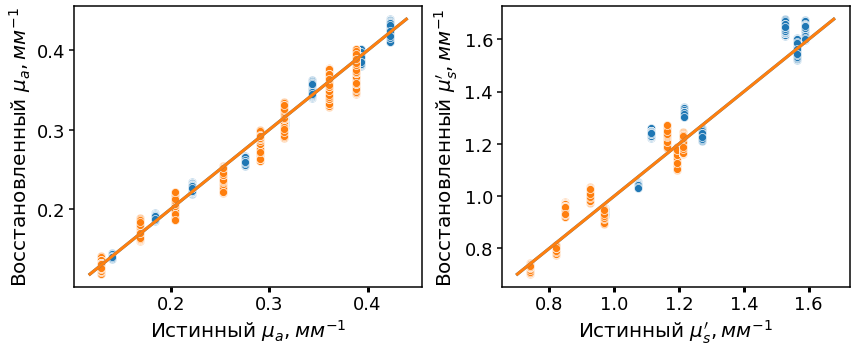

In [78]:
best_alphas  = []
for ref in ['070_090']:
    _df = df[(df.reference == ref)&(df.alpha<0.34)&(df.alpha>0.31)]
    
    
    plt.figure(figsize=(12,5))
    
    for wavelength in _df.wavelength.unique():
        plt.subplot(1,2,1)
        
        mask = _df.wavelength == wavelength
        x = np.linspace(_df['mua'].min(),_df['mua'].max())
        sns.scatterplot(_df['true_mua'][mask],_df['mua'][mask])
        plt.plot(x,x)
        plt.xlabel(r"Истинный $\mu_a, мм^{-1}$")
        plt.ylabel(r"Восстановленный $\mu_a, мм^{-1}$")
        plt.subplot(1,2,2)
        sns.scatterplot(_df['true_mus'][mask],_df['mus'][mask])

        s = np.linspace(_df.mus.min(),_df.mus.max())

        plt.plot(s,s)
    
    plt.xlabel(r"Истинный $\mu_s', мм^{-1}$")
    plt.ylabel(r"Восстановленный $\mu_s', мм^{-1}$")
    plt.tight_layout()
    plt.show()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


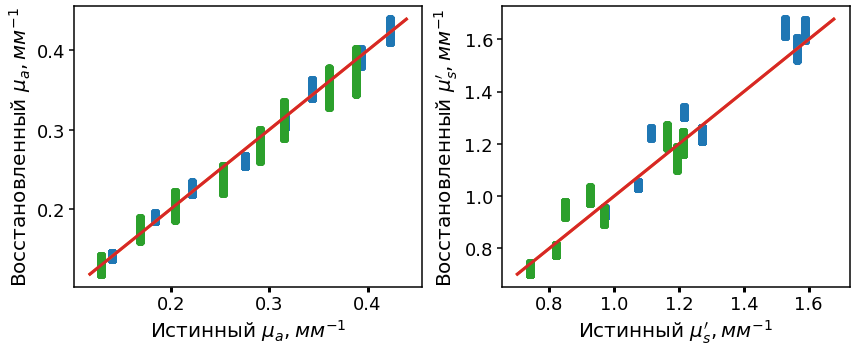

In [66]:
np.mean(best_alphas)

0.42013888888888884

### What to do next?
1. Real values of mua and mus and reprocessing
2. Good mask for fitting only reliable regions
3. Dependency of error on the binning
4. Characteristic R(k) curves for various pixels for different binning values
5. Implement multiprocessing for fitting (may be using eigen values)
6. Reformat to module
7. Измерить концентрации липофундина и нигрозина для конкретных значений мг/мл и использовать их спектры для реализации функции `get_mua_mus` вместо имени файла и эмпирических коэффициентов!

In [40]:
best_alpha = alphas[np.argmax(r2s)]
print(f"Best alpha : {best_alpha:.3f}")

Best alpha : 0.329


In [55]:
diffuse_model = fitter.DiffuseModel()

In [57]:
verbose = False
reflectances = {}

for sample_folder in folders:
    sample_name = get_sample_name(sample_folder)
    wavelength = get_wavelength(sample_folder)

    name = f'{sample_name}_wv={wavelength}'
        #calculating reference absorption and scattering for reference phantom
    ref_freqs,ref_binned_mac = reference_phantoms[wavelength]

    print(f'Fitting {name}',end='... ')
        #read and preprocessing the input sample
    test_freqs, mac_1 = preprocess.read_and_preprocess(sample_folder=sample_folder,
                                                  binning_kernel_size=9,
                                                  verbose=verbose)

    try:
        test_freqs, mac_2 = preprocess.read_and_preprocess(sample_folder=sample_folder,
                                                      binning_kernel_size=9,start_phase=3,
                                                      verbose=verbose)
    except ValueError:
        print(f"Something went wrong when reading {sample_folder}")
        mac_2 = mac_1.copy()

    binned_mac = np.sqrt((mac_1**2 + mac_2**2)/2)


    spatial_frequencies = calculate_real_frequencies_from_prepends(test_freqs)
    spatial_frequencies_ref = calculate_real_frequencies_from_prepends(ref_freqs)

    mua_ref,mus_ref = get_mua_mus(reference_phantom_name,wavelength)

    mus_ref = best_alpha*mus_ref
#     reflectance_stack = fitter.get_reflectance_stack(freqs_test=spatial_frequencies,
#                               mac_test=binned_mac,
#                               freqs_reference=spatial_frequencies_ref,
#                               mac_reference=ref_binned_mac,
#                                                  ref_mua=mua_ref,
#                                                  ref_mus_prime=mus_ref)


    ref_mask  = get_mask_for_phantom(ref_binned_mac,verbose=False)
    test_mask = get_mask_for_phantom(binned_mac,verbose=False)
    fit_mask = skmorph.erosion(ref_mask&test_mask,selem=np.ones((11,11)))


    reflectance_stack[:,~fit_mask] = np.nan

    fit_results = fitter.fit_diffuse_reflectance_stack(spatial_frequencies,reflectance_stack,
                                      fit_mask=fit_mask,diffuse_model=diffuse_model,backend='cpp')

#     results[name] = fit_results
    
    name = f'a={mua_ref:.4f}_s={mus_ref:.4f}_wv={wavelength}'
    reflectances[name] = spatial_frequencies,reflectance_stack

Fitting 040_100_wv=560... 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19


res.sizes() 5 81920
Fitting 100_140_wv=560... res.sizes() 5 81920
Fitting 060_080_wv=560... res.sizes() 5 81920
Fitting 050_130_wv=560... res.sizes() 5 81920
Fitting 080_140_wv=560... res.sizes() 5 81920
Fitting 070_090_wv=560... res.sizes() 5 81920
Fitting 090_110_wv=560... res.sizes() 5 81920
Fitting 030_090_wv=560... res.sizes() 5 81920
Fitting 040_100_wv=630... res.sizes() 5 81920
Fitting 100_140_wv=630... res.sizes() 5 81920
Fitting 060_080_wv=630... res.sizes() 5 81920
Fitting 050_130_wv=630... res.sizes() 5 81920
Fitting 080_140_wv=630... res.sizes() 5 81920
Fitting 070_090_wv=630... res.sizes() 5 81920
Fitting 090_110_wv=630... res.sizes() 5 81920
Fitting 030_090_wv=630... res.sizes() 5 81920


In [59]:
reflectances

{'a=0.3161_s=1.0602_wv=560': (array([0.03926991, 0.07853982, 0.15707963, 0.23561945, 0.31415927,
         0.39269908, 0.4712389 , 0.54977871, 0.70685835, 0.86393798,
         1.02101761, 1.25663706, 1.33517688, 1.41371669, 1.57079633,
         1.72787596]),
  array([[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
  
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
  
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],

(array([5137., 2897., 6290., 6168., 5434., 6538., 3660., 7500., 4031.,
        2989.]),
 array([0.11846266, 0.15039966, 0.18233666, 0.21427366, 0.24621067,
        0.27814767, 0.31008467, 0.34202167, 0.37395867, 0.40589567,
        0.43783267]),
 <BarContainer object of 10 artists>)

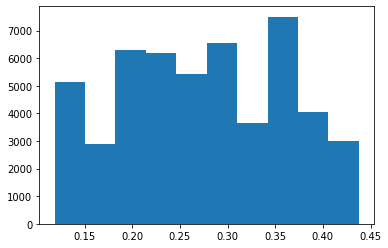

In [28]:
plt.hist(best_df['mua'])

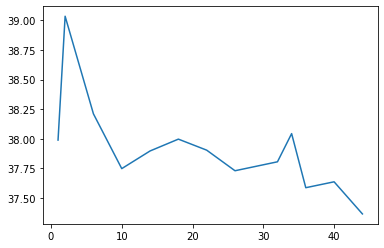

In [62]:
plt.plot(freqs,mdc_stack[:,600:610,800:810].sum(axis=(1,2)))

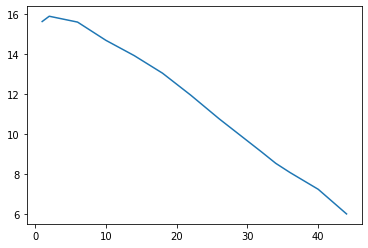

In [63]:
plt.plot(freqs,mac_stack[:,600:610,800:810].sum(axis=(1,2)))

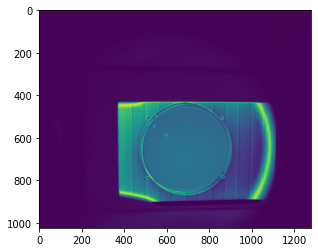

In [64]:
plt.imshow(mac_stack.sum(axis=0))

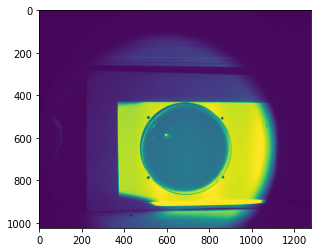

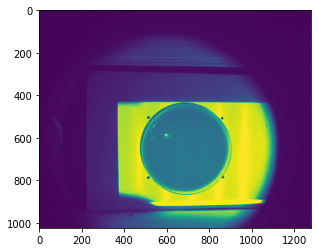

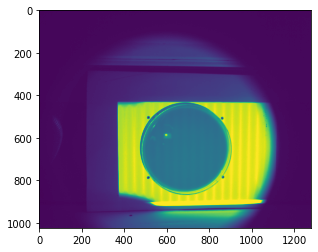

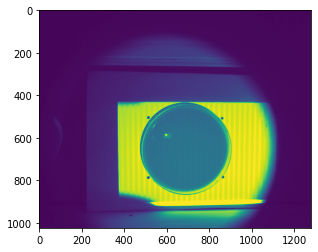

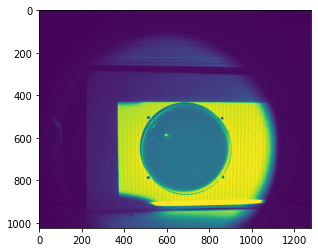

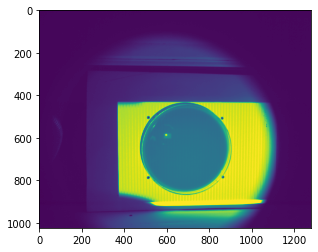

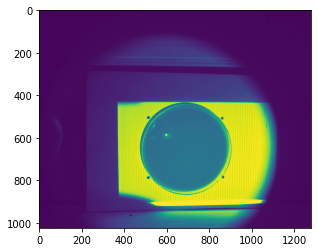

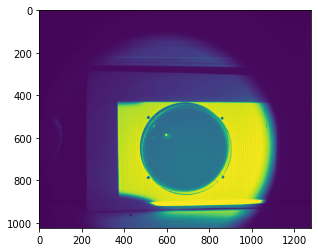

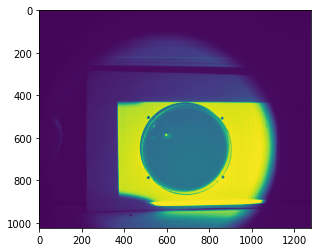

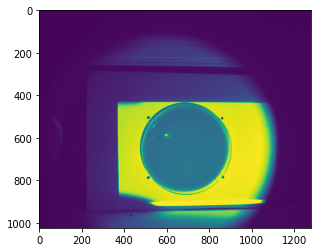

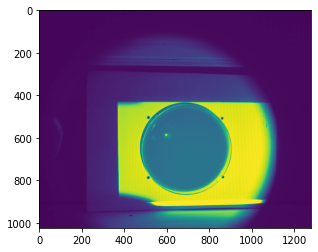

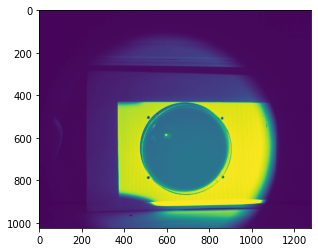

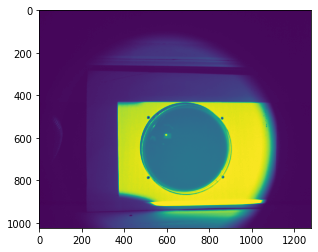

In [65]:
for mdc in mdc_stack:
    plt.figure()
    plt.imshow(mdc,vmin=0,vmax=1)

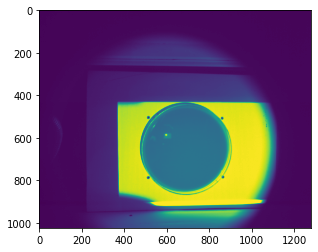

In [66]:
plt.imshow(mdc)